In [96]:
import tensorflow
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import keras
from tensorflow import image
import tensorflow_addons as tfa
from collections import Counter


In [9]:
batch_size = 32
img_height = 128
img_width = 128
IMG_SIZE = (img_height,img_width)

In [142]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "train/",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "real_imgs/",
  #validation_split=0.2,
  #subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

AUTOTUNE = tf.data.experimental.AUTOTUNE


Found 1481 files belonging to 3 classes.
Using 1185 files for training.
Found 402 files belonging to 3 classes.


In [143]:
#augment training data
def random_shift_img(x):
    if tf.random.uniform([])< 0.6:
        shift = tf.random.uniform([],minval=-250,maxval = 255)
        return x+shift
    else:
        return x
    

class RandomShift(layers.Layer):
    def __init__(self,dynamic = True, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        return random_shift_img(x)


class Stretch(layers.Layer):
    def __init__(self,dynamic = True, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        return tfa.image.transform(x, [0.5, 0, -250, 0.0, 1, 0.0, 0, 0.0])

    
    
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom((-0.3,0)),
    #to_grey
    #RandomShift(),
  ]
)
    

def prepare(ds):
    ds = ds.map(lambda x, y: (data_augmentation(x), y), 
                num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds.unbatch().batch(1)).unbatch().batch(batch_size)


In [144]:

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [145]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [146]:
base_model.trainable = False


In [147]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3)

inputs = tf.keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [148]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [149]:
initial_epochs = 15

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

#loss0, accuracy0 = model.evaluate(val_ds)

Epoch 1/15
38/38 [==============================] - 32s 843ms/step - loss: 1.5250 - accuracy: 0.3595 - val_loss: 1.2526 - val_accuracy: 0.3632
Epoch 2/15
38/38 [==============================] - 21s 542ms/step - loss: 1.0788 - accuracy: 0.4776 - val_loss: 1.0742 - val_accuracy: 0.5100
Epoch 3/15
38/38 [==============================] - 22s 580ms/step - loss: 0.9175 - accuracy: 0.5907 - val_loss: 0.9574 - val_accuracy: 0.5821
Epoch 4/15
38/38 [==============================] - 23s 610ms/step - loss: 0.7867 - accuracy: 0.6422 - val_loss: 0.8767 - val_accuracy: 0.6095
Epoch 5/15
38/38 [==============================] - 21s 562ms/step - loss: 0.7072 - accuracy: 0.6852 - val_loss: 0.8188 - val_accuracy: 0.6443
Epoch 6/15
38/38 [==============================] - 22s 570ms/step - loss: 0.6200 - accuracy: 0.7426 - val_loss: 0.7799 - val_accuracy: 0.6791
Epoch 7/15
38/38 [==============================] - 20s 518ms/step - loss: 0.5561 - accuracy: 0.7789 - val_loss: 0.7402 - val_accuracy: 0.6965

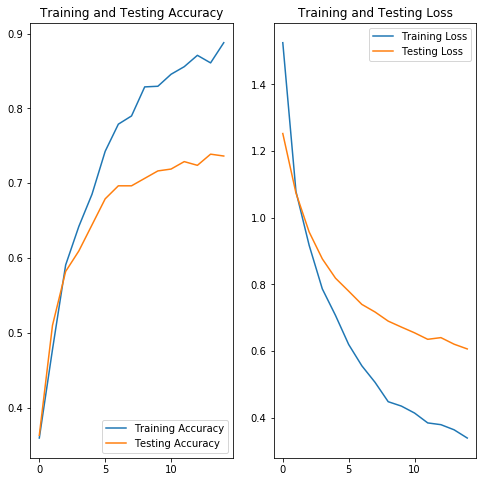

In [151]:
epochs = 15
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.show()

In [152]:
model.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential_12 (Sequential)   (None, 128, 128, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_12 (Tens [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_12 (TensorFl [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_13  (None, 1280)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1280)            

In [121]:
#test NN on real images
real_img_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "real_imgs/",
  batch_size = 1,
  seed=123,
  image_size=(img_height, img_width))

results = model.evaluate(real_img_ds)


Found 402 files belonging to 3 classes.
402/402 [==============================] - 13s 32ms/step - loss: 0.6474 - accuracy: 0.7388


In [66]:
img = keras.preprocessing.image.load_img(
    'real_imgs/imfd/badnose88.jpg', target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

model.predict(img_array)

array([[ 1.0789886 ,  1.5268726 , -0.40687537]], dtype=float32)

In [94]:
directory1 = 'real_imgs/cmfd'
results1 = []
for filename in os.listdir(directory1):
    if filename.endswith(".jpg") :
        img = keras.preprocessing.image.load_img(os.path.join(directory1,filename), target_size=(img_height, img_width))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        result = model.predict(img_array)
        idx  = result[0].argmax()
        results1.append(idx)
    else:
        continue
        
directory2 = 'real_imgs/imfd'
results2 = []
for filename in os.listdir(directory2):
    if filename.endswith(".jpg") :
        img = keras.preprocessing.image.load_img(os.path.join(directory2,filename), target_size=(img_height, img_width))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        result = model.predict(img_array)
        idx  = result[0].argmax()
        results2.append(idx)
    else:
        continue

directory3 = 'real_imgs/nomask'
results3 = []
for filename in os.listdir(directory3):
    if filename.endswith(".jpg") :
        img = keras.preprocessing.image.load_img(os.path.join(directory3,filename), target_size=(img_height, img_width))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        result = model.predict(img_array)
        idx  = result[0].argmax()
        results3.append(idx)
    else:
        continue

Text(0, 0.5, 'Accuracy')

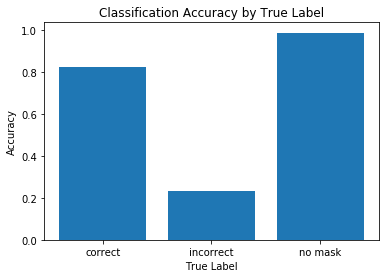

In [97]:
correct_classification_percent = [Counter(results1)[0]/len(results1),Counter(results2)[1]/len(results2),Counter(results3)[2]/len(results3)]
plt.bar(['correct','incorrect','no mask'],correct_classification_percent)
plt.title("Classification Accuracy by True Label")
plt.xlabel('True Label')
plt.ylabel('Accuracy')

<BarContainer object of 3 artists>

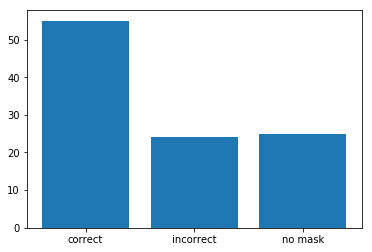

In [98]:
imfd_predictions = [Counter(results2)[0],Counter(results2)[1],Counter(results2)[2]]
plt.bar(['correct','incorrect','no mask'],imfd_predictions)